In [2]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

# Cifar 100 Dataset
using the cifar100 dataset for image classificaiton
CIFAR-10 dataset has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).

In [3]:
project_name = 'cifar100-dataset-project'

In [4]:
#downloading the dataset
dataset_url = 'https://s3.amazonaws.com/fast-ai-imageclas/cifar100.tgz'
download_url(dataset_url,'.')

In [5]:
with tarfile.open('./cifar100.tgz','r:gz') as tar:
  tar.extractall(path = './data')

In [6]:
data_dir = './data/cifar100'

In [7]:
print(os.listdir(data_dir))

['train', 'test']


In [8]:
superclasses = os.listdir(data_dir + "/train")
print(superclasses)

['large_carnivores', 'large_natural_outdoor_scenes', 'large_omnivores_and_herbivores', 'flowers', 'medium_mammals', 'vehicles_1', 'vehicles_2', 'reptiles', 'aquatic_mammals', 'small_mammals', 'large_man-made_outdoor_things', 'trees', 'people', 'food_containers', 'household_furniture', 'insects', 'household_electrical_devices', 'fruit_and_vegetables', 'fish', 'non-insect_invertebrates']


number of classes indide super class fish


In [9]:
classes = os.listdir(data_dir + "/train/fish" )
print(classes)

['aquarium_fish', 'trout', 'ray', 'flatfish', 'shark']


In [10]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [11]:
dataset = ImageFolder(data_dir+"/train", transform = ToTensor())

In [12]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 32, 32]) 0


tensor([[[0.6196, 0.6431, 0.6392,  ..., 0.5843, 0.5451, 0.4941],
         [0.6039, 0.6353, 0.6353,  ..., 0.5843, 0.5490, 0.4980],
         [0.6078, 0.6431, 0.6431,  ..., 0.5804, 0.5490, 0.5020],
         ...,
         [0.7059, 0.7216, 0.6863,  ..., 0.8549, 0.8471, 0.7961],
         [0.8902, 0.8667, 0.7804,  ..., 0.9569, 0.9647, 0.9451],
         [0.9804, 0.9647, 0.9098,  ..., 0.9843, 0.9843, 0.9451]],

        [[0.6314, 0.6745, 0.6863,  ..., 0.5804, 0.5490, 0.5137],
         [0.6275, 0.6824, 0.6902,  ..., 0.5922, 0.5647, 0.5294],
         [0.6353, 0.6902, 0.6980,  ..., 0.5961, 0.5765, 0.5333],
         ...,
         [0.7608, 0.7804, 0.7490,  ..., 0.8745, 0.8706, 0.8196],
         [0.9216, 0.9059, 0.8275,  ..., 0.9725, 0.9765, 0.9647],
         [0.9922, 0.9804, 0.9333,  ..., 0.9922, 0.9922, 0.9608]],

        [[0.3922, 0.3843, 0.3765,  ..., 0.3725, 0.3451, 0.3255],
         [0.3843, 0.3843, 0.3765,  ..., 0.3725, 0.3529, 0.3294],
         [0.3765, 0.3843, 0.3765,  ..., 0.3765, 0.3686, 0.

In [13]:
print(dataset.classes)

['aquatic_mammals', 'fish', 'flowers', 'food_containers', 'fruit_and_vegetables', 'household_electrical_devices', 'household_furniture', 'insects', 'large_carnivores', 'large_man-made_outdoor_things', 'large_natural_outdoor_scenes', 'large_omnivores_and_herbivores', 'medium_mammals', 'non-insect_invertebrates', 'people', 'reptiles', 'small_mammals', 'trees', 'vehicles_1', 'vehicles_2']


In [14]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [15]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Example image from dataset

Label:  aquatic_mammals (0)


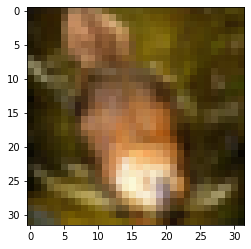

In [19]:
show_example(*dataset[70])

In [20]:
random_seed = 26
torch.manual_seed(random_seed);

since there is no validation layer hence here we devide this dataset of of 50,000 elements in validation and training sizes of 10,000 and 40,000 resp


In [21]:
validation_size = 10000
training_size = len(dataset) - validation_size

training_ds, validation_ds = random_split(dataset, [training_size, validation_size])

now just taking note of the metrics


In [22]:
jovian.log_dataset(dataset_url=dataset_url, validation_size=validation_size, random_seed=random_seed)

[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Dataset logged.


now creating training and validation dataloaders


In [23]:
from torch.utils.data.dataloader import DataLoader
batch_size = 128

training_dl = DataLoader(training_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
validation_dl = DataLoader(validation_ds, batch_size*2, num_workers=4, pin_memory=True)

Using CNN to make model more accurate


In [24]:
def apply_kernel(image, kernel):
    ri, ci = image.shape       # for image
    rk, ck = kernel.shape      # for kernel
    ro, co = ri-rk+1, ci-ck+1  # for output my multiplying image matrix with kernel then adding all values
    output = torch.zeros([ro, co])
    for i in range(ro): 
        for j in range(co):
            output[i,j] = torch.sum(image[i:i+rk,j:j+ck] * kernel)
    return output

In [25]:
import torch.nn as nn
import torch.nn.functional as F

Now we finally set out to create a model which will be used to train on this dataset


In [36]:
class ImageClassificationXtended(nn.Module):
   def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  
        loss = F.cross_entropy(out, labels) # using cross-entropy function to calculate loss
                                            # because we want final answer as probablity 
        return loss
    
   def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   # Calculate accuracy for better validation
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
   def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combining losses from different epochs
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combining accuracy from different epochs
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
   def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)                                    
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))                


In [67]:
class MyProjectModel(ImageClassificationXtended):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),                             #keeping the padding and stride 1 so as to obtain the output matrix same size as input matrix
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16                                     #max pool to reduce length and breadth

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),      
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),      
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),      
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 20))
        
    def forward(self, xb):
        return self.network(xb)

multiple layers of convu2d and ReLu to introduce non linearity in model 
these multiple layers are used in nn.sequential so that it performs these operations on layers

In [68]:
model = MyProjectModel()


now that we have defined our models, here are some formalities for using the GPU
also if GPU is not present we will use the CPU

In [69]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [70]:
device = get_default_device()

following command is used to pass out data loader to the GPU

In [71]:
training_dl = DeviceDataLoader(training_dl, device)
validation_dl = DeviceDataLoader(validation_dl, device)
to_device(model, device);

now we start training the model

In [72]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

now training for 5 epochs and using Adam as optimiser


In [73]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

before beginning the actual training, taking note of hyperparameters

In [74]:
jovian.reset()
jovian.log_hyperparams({
    'num_epochs': num_epochs,
    'opt_func': opt_func.__name__,
    'batch_size': batch_size,
    'lr': lr,
})

[jovian] Hyperparams logged.


now training the model and seeing the accuracy 

In [75]:
history = fit(num_epochs, lr, model, training_dl, validation_dl, opt_func)

Epoch [0], train_loss: 2.7968, val_loss: 2.5442, val_acc: 0.1884
Epoch [1], train_loss: 2.4413, val_loss: 2.3242, val_acc: 0.2659
Epoch [2], train_loss: 2.2490, val_loss: 2.2115, val_acc: 0.3077
Epoch [3], train_loss: 2.0852, val_loss: 2.0461, val_acc: 0.3523
Epoch [4], train_loss: 1.9423, val_loss: 1.9362, val_acc: 0.3934
Epoch [5], train_loss: 1.8142, val_loss: 1.8693, val_acc: 0.4057
Epoch [6], train_loss: 1.7030, val_loss: 1.7933, val_acc: 0.4329
Epoch [7], train_loss: 1.5935, val_loss: 1.7634, val_acc: 0.4476
Epoch [8], train_loss: 1.4895, val_loss: 1.7289, val_acc: 0.4602
Epoch [9], train_loss: 1.3795, val_loss: 1.7498, val_acc: 0.4536


training a few more epochs with a lower leaning rate

In [76]:
lr = 0.0001

In [77]:
history = fit(num_epochs, lr, model, training_dl, validation_dl, opt_func)

Epoch [0], train_loss: 1.0919, val_loss: 1.7171, val_acc: 0.4923
Epoch [1], train_loss: 1.0150, val_loss: 1.7410, val_acc: 0.4924
Epoch [2], train_loss: 0.9706, val_loss: 1.7625, val_acc: 0.4861
Epoch [3], train_loss: 0.9346, val_loss: 1.7873, val_acc: 0.4944
Epoch [4], train_loss: 0.8995, val_loss: 1.8269, val_acc: 0.4893
Epoch [5], train_loss: 0.8651, val_loss: 1.8528, val_acc: 0.4935
Epoch [6], train_loss: 0.8312, val_loss: 1.8720, val_acc: 0.4925
Epoch [7], train_loss: 0.7979, val_loss: 1.9198, val_acc: 0.4913
Epoch [8], train_loss: 0.7628, val_loss: 1.9526, val_acc: 0.4915
Epoch [9], train_loss: 0.7280, val_loss: 1.9822, val_acc: 0.4938


noting down the metrics

In [78]:
jovian.log_metrics(train_loss=history[-1]['train_loss'], 
                   val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'])

[jovian] Metrics logged.


graph of accuracy

In [83]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

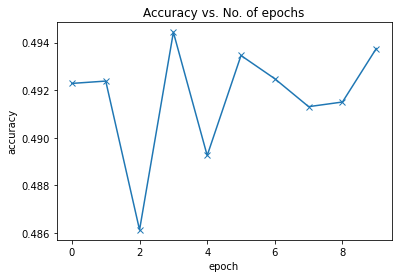

In [84]:
plot_accuracies(history)

now testing the model with test dataset

In [85]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

making function for prediction

In [90]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: aquatic_mammals , Predicted: aquatic_mammals


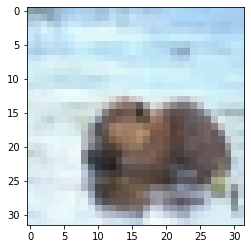

In [91]:
img, label = test_dataset[80]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: aquatic_mammals , Predicted: household_electrical_devices


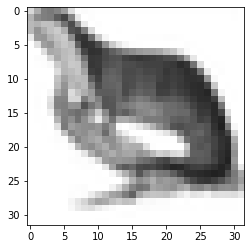

In [92]:
img, label = test_dataset[200]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: household_furniture , Predicted: household_furniture


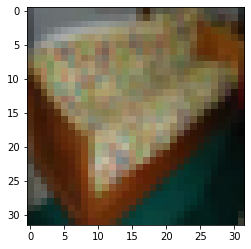

In [93]:
img, label = test_dataset[3211]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: fish , Predicted: fish


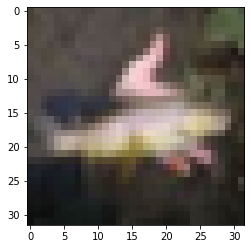

In [94]:
img, label = test_dataset[999]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Now look at the final loss and accuracy and taking note of them

In [95]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.486328125, 'val_loss': 2.014551877975464}

In [96]:
jovian.log_metrics(test_loss=result['val_loss'], test_acc=result['val_acc'])

[jovian] Metrics logged.


Saving the model and its weights

In [97]:
torch.save(model.state_dict(), 'cifar100-cnn-aman.pth')

In [ ]:
!pip install jovian --upgrade --quiet

In [88]:
import jovian

In [101]:
jovian.commit(project=project_name)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...


ApiError: ignored

#Conclusion and What i learnt

During the course of these 6-8 weeks i have leaned a lot 
starting with first class i leaned linear regression, that was the day when i first realized the real meaning of machine leaning and the fact that machine could predict yeild of apples totally blew my mind and gave me goosebumps

next i learned logistic regression and learnt how images can be treated and fec=d as matrices and had my first experience with the Mnist class.

Next class was on nueral network in which we added multiple layers between output and hidden layer and used it to create non linearity.We also saw how we can move our data to GPU in this module

the next class was based on CNN on which my project is based too
CNN is the most interesting thing i like in whole of this course.
The idea of kernel sliding over the input matrix to capture relations is just too much of an amazing concept.

Next lesson was more about improving accuracy of model and dealing with the problem of it not doing good on Test and Validation Dataset.

Last lecture was also an amazing one and second best after CNN lecture. We saw how to generate anime faces, i am looking forward to use same tech to generate pokemon faces.

Very very thanks to Jovian for providing me this opportunity to learn so much that too free of cost.
Also cheers for our teacher Aakash sir who BTW i am a fan now,
he taught so so well with patience, going over everything and explaining everything.
I never thought i would learn this much in 6-8 weeks.
Again thank you so much Jovian
